In [1]:
# get the training data (e.g. all the data we have previously on the park), 1 num_timesteps initially, each running for 5 steps
# train the prediction model 
# have it predict probs for the most recent timestep 
# take those probabilities and give it to singleplanner and run for 5 steps  
# repeat

from paws import data_generation, multiple_timesteps, create_dataframe, iWare, setup_data, discretization
import numpy as np
import pandas as pd
from SinglePlanner import SinglePlanner
import random

file1 = "GeneratedData/paws_preds.npy"
file2 = "GeneratedData/paws_traps.npy"
file3 = "GeneratedData/paws_prey.npy"
#data_generation(file1, file2, file3) 

M = 25
N = 25

def retrain_model(preds, traps):
    df = create_dataframe(preds, traps)
    features, labels, effort, timestamps = setup_data(df)
    iware = iWare()
    train_x, test_x, train_y, test_y, train_effort, test_effort = iware.train_test_split_by_year(features, labels, effort, timestamps, max(timestamps))
    iware.train_iware(train_x, train_y, train_effort)
    return iware

def milp_traps(M, N, iware): 
    return np.random.binomial(1,1/2,(M,N))*10
    traps = np.zeros((M,N))    
    effortx, data = discretization(iware)
    sp = SinglePlanner()
    sol = sp.test(effortx, data)
    traps = np.array(sol).reshape((M,N))
    return traps

def run(file1, file2, file3):
    # initial data stuff 
    pred_densities, trap_densities, prey_densities = np.load(file1), np.load(file2), np.load(file3)
    df_dict = {"Timestamps": [], "Label": [], "X": [], "Y": [], "Density": [], "Trap Effort": [], "Previous Success": []}
    df = pd.DataFrame(df_dict)

    # how many times we retrain model and call milp_traps 
    for idx in range(5): 
        # start using the milp generated traps 
        #iware = retrain_model(pred_densities, trap_densities)
        iware = None #for randomly generating traps
        prey_densities, pred_densities, trap_densities = multiple_timesteps(prey_densities, pred_densities, trap_densities, milp_traps(M, N, iware))
    return prey_densities, pred_densities 

prey, pred = run(file1, file2, file3)   

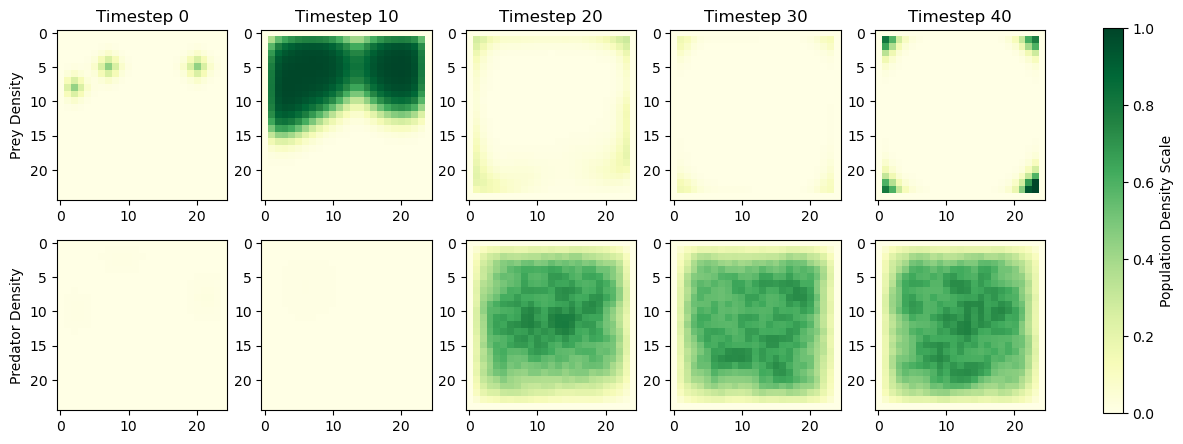

In [2]:
from ipywidgets import interact, IntSlider 
import matplotlib.pyplot as plt 
from matplotlib import colors

def plot_densities_at_timestep(prey_densities, pred_densities): 
    min1, max1 = np.amin(pred_densities), np.amax(pred_densities)
    min2, max2 = np.amin(prey_densities), np.amax(prey_densities)
    _min, _max = min(min1, min2), max(max1, max2)
    norm = colors.Normalize(vmin=_min, vmax=_max)
    fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(15,5))
    for col in range(5):
        im = axs[1,col].imshow(pred_densities[:, :, 10*col], cmap=plt.cm.YlGn, vmin=_min, vmax=_max)
        im.set_norm(norm)
        im = axs[0,col].imshow(prey_densities[:, :, 10*col], cmap=plt.cm.YlGn, vmin=_min, vmax=_max)
        im.set_norm(norm)
        axs[0,col].set_title("Timestep %d"%(10*col))
    axs[0,0].set_ylabel("Prey Density")
    axs[1,0].set_ylabel("Predator Density")
    norm = colors.Normalize(vmin=0,vmax=1)
    im.set_norm(norm)
    cbar = plt.colorbar(im,ax=axs, orientation='vertical', fraction=.1)
    cbar.ax.set_ylabel("Population Density Scale")
    #plt.savefig("paws.png", bbox_inches="tight")
    plt.savefig("half+eff_trap.png", bbox_inches="tight")
plot_densities_at_timestep(prey, pred)



In [3]:
from ipywidgets import interact, IntSlider, fixed
import matplotlib.pyplot as plt 

interact(plot_densities_at_timestep, prey_densities=fixed(prey), pred_densities=fixed(pred), timestep=IntSlider(min=0, max=100, step=1, value=0))


interactive(children=(Output(),), _dom_classes=('widget-interact',))

<function __main__.plot_densities_at_timestep(prey_densities, pred_densities)>